# Practice #3. "Dynamic predictive models"

This notebook is dedicated to:
* Residual analisys. Dickey-Fuller test
* Autocorelation analisys
* Predicting Time series: AR Model

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import boxcox

import warnings
warnings.filterwarnings('ignore')

## 0. Data reading and visualization

Please, specify path to data

In [78]:
path_to_datafile = "../data/daily-min-temperatures.csv"

In [79]:
# data reading to pandas.DataFrame
df = pd.read_csv(path_to_datafile)

Please, rename time column to `ds` and data column to `y`(you can use `df.rename`) . If use dataset with multiple features select only one and drop NaN values

In [80]:
# your code here
df.rename(columns={"Date": "ds", "Temp": "y"}, inplace=True)
#"Date","Births""Month","Passengers""Date","Temp"
df.dropna(inplace=True)

Convert date column to datetime format and set as index

In [81]:
df["ds"] = pd.to_datetime(df["ds"])
df.set_index("ds", inplace=True)

Number of data data points:

In [82]:
df.shape[0]

3650

Print slice of the timeseries:

In [83]:
df.head()

,y
ds,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Let's plot the data

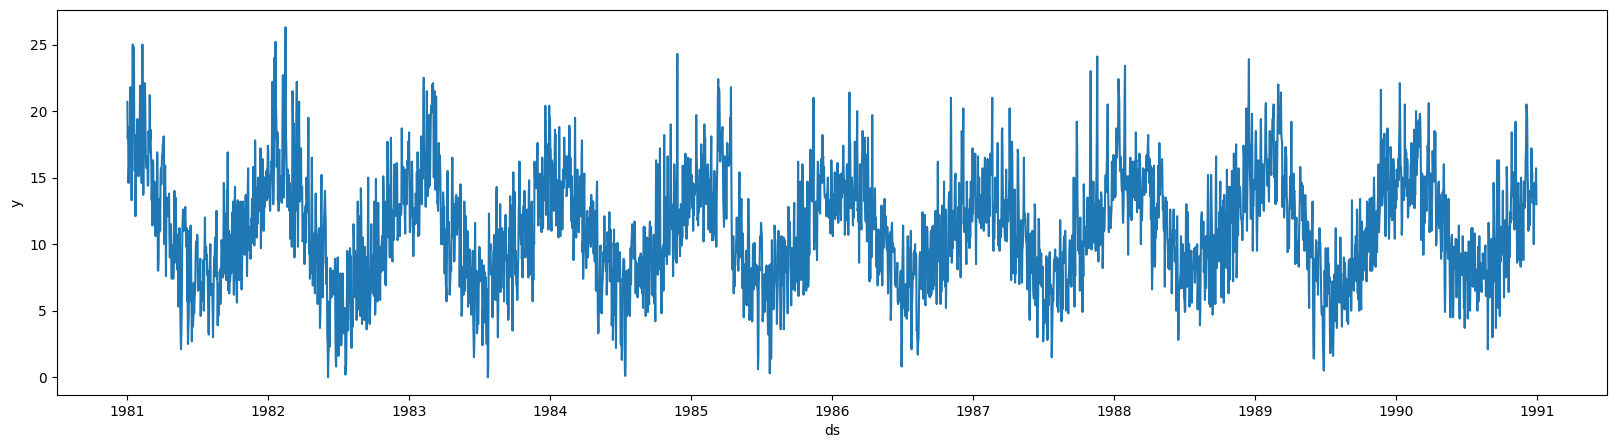

In [84]:
plt.figure(figsize=(20, 5))
plt.ylabel("y")
plt.xlabel("ds")
plt.plot(df);

## 1. Residual analysis. Dickey-Fuller test

First, let's describe one of the time series properties like stationarity. A stationary process is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time. This property is described by pictures from the [post](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/).

![title](https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png)
![title](https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png)
![title](https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png)

So Dickey-Fuller test allows us to check a time series stationarity. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time-dependent structure.<br>
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise, a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.<br>
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

It’s better to have the p-value to be smaller than 0.05 in order to reject the null hypothesis and consider data as stationary.

Example:

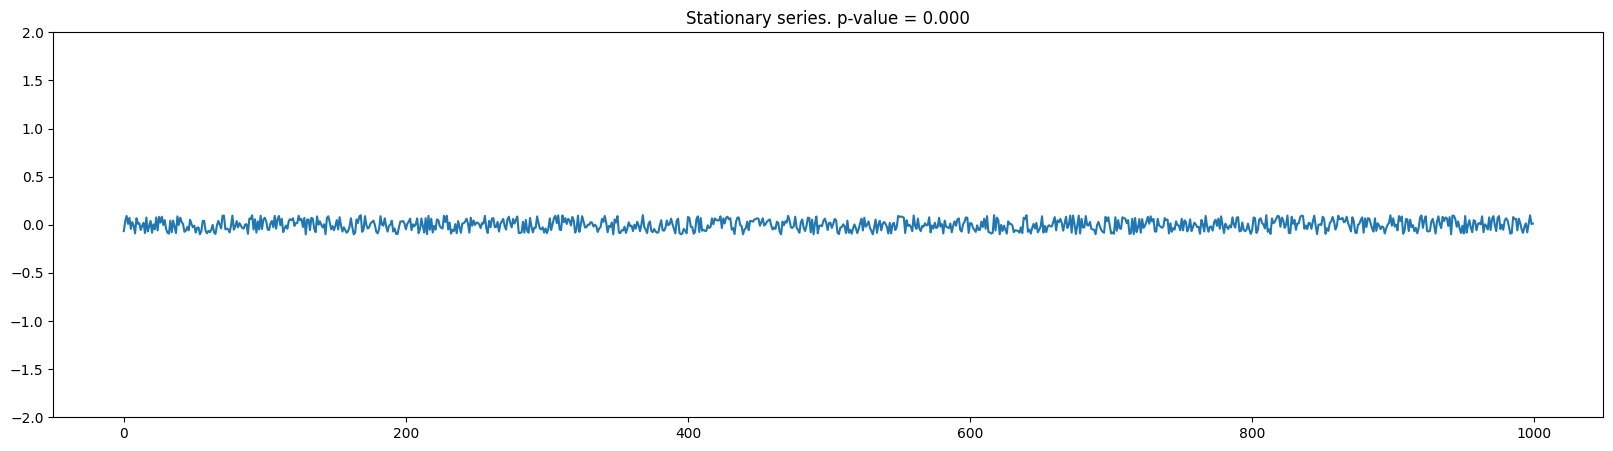

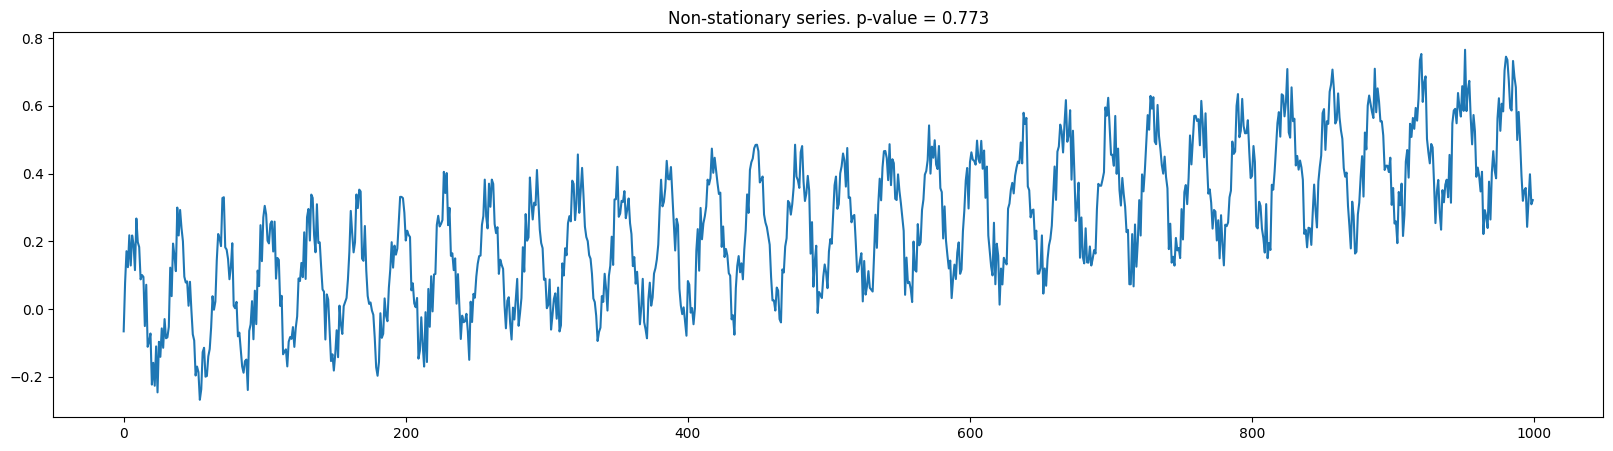

In [85]:
stationary_series = np.random.rand(1000) * 0.2 - 0.1
nonstationary_series = (stationary_series + np.linspace(0, 0.5, 1000) + np.sin(np.arange(1000) / 5) / 5)

result = adfuller(stationary_series)

plt.figure(figsize=(20, 5))
plt.plot(stationary_series)
plt.ylim(-2, +2)
plt.title(f"Stationary series. p-value = {result[1]:.03f}");

result = adfuller(nonstationary_series)

plt.figure(figsize=(20, 5))
plt.plot(nonstationary_series)
#plt.ylim(-2, +2)
plt.title(f"Non-stationary series. p-value = {result[1]:.03f}");

Please, do Dickey-Fuller test using `statsmodels.tsa.stattools.adfuller`

In [86]:

result = adfuller(df)
print("ADF Statistic:", result[0])
print(f"p-value: {result[1]:.03f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

if result[1] < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -4.44480492461167
p-value: 0.000
Critical Values:
   1%: -3.4321532327220154
   5%: -2.862336767636517
   10%: -2.56719413172842
The series is stationary (reject the null hypothesis).


Usually, predictive models like AR or ARIMA required stationary series. Because they modeling the mean and deviation of a time series using the hypothesis that characteristics of the series not changed over time.<br>
There multiple methods to make a time series stationary:
- Differencing to remove trend. Differencing is performed by subtracting the previous observation from the current observation
- Lag differencing to remove seasonality - a substracting observation on the distance $m$ - seasons period
- Box-Cox Transformation to normalize variance

Please, make your time series stationary

In [87]:
# 1. Differencing to remove trend
df['y_diff'] = df['y'].diff()  # First-order differencing
p_value_diff = adfuller(df['y_diff'].dropna())[1]
print(f'After differencing (trend removal), p-value: {p_value_diff}')

# 2. Seasonal differencing
m = 360
df['y_seasonal_diff'] = df['y'].diff(m)
p_value_seasonal_diff = adfuller(df['y_seasonal_diff'].dropna())[1]
print(f'After seasonal differencing, p-value: {p_value_seasonal_diff}')

# 3. Box-Cox transformation
df['positive_y'] = df['y'] - df['y'].min() + 1
df['y_boxcox'], lambda_value = boxcox(df['positive_y'])

# Stationarity test on the transformed data
p_value_boxcox = adfuller(df['y_boxcox'])[1]
print(f'After Box-Cox transformation, p-value: {p_value_boxcox}')


print(f'Box-Cox lambda value: {lambda_value}')

After differencing (trend removal), p-value: 2.681561822675177e-30
After seasonal differencing, p-value: 4.6469416047312366e-30
After Box-Cox transformation, p-value: 0.0002948495196893113
Box-Cox lambda value: 0.8265403804231072


## 2. Autocorelation analysis

Autocorrelation refers to the degree of correlation of the same variables between two successive time intervals. It measures how the lagged version of the value of a variable is related to the original version of it in a time series.<br>
In statistics, the autocorrelation of a real or complex random process is the Pearson correlation between values of the process at different times, as a function of the two times or of the time lag. Using this technique we can detect the seasonality of time series.<br>
A very helpful instrument in autocorrelation analysis is an autocorrelation plot, where on the x-axis - lags and y-axis - correlation value. Also, the plot can include dotted or solid lines that tell about the statistical significance of the correlation. Each spike that rises above or falls below the dashed lines is considered to be statistically significant.<br>
In python there myltple methods to build autocorrelation plot: `pandas.plotting.autocorrelation_plot` and `statsmodels.graphics.tsaplots import plot_acf`.

The example below shows the autocorrelation plot for nonstationary series from the example above:

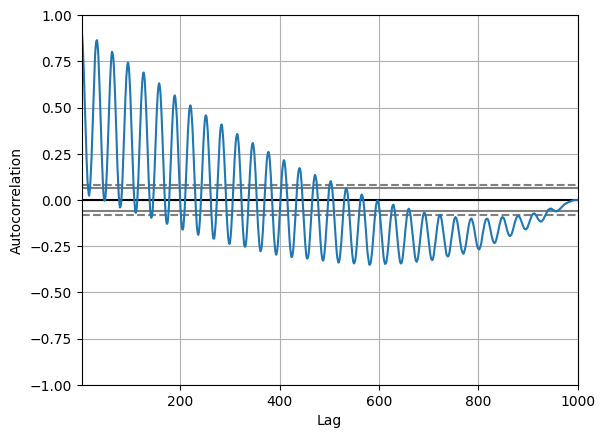

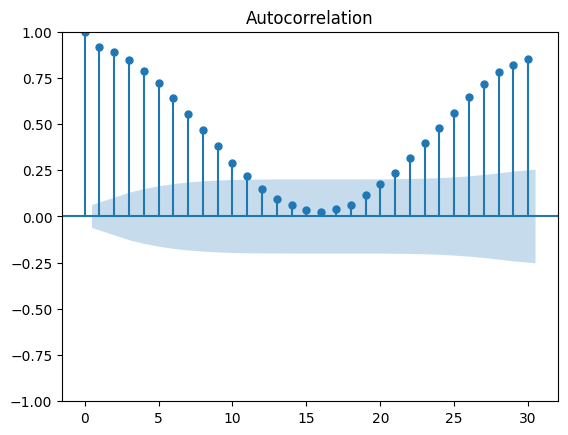

In [88]:
pd.plotting.autocorrelation_plot(nonstationary_series);
plot_acf(nonstationary_series);

On the plots above, we can see peaks of autocorrelation with period equals $\pi$. And if there are some peaks this means that we can model the time-series using an autoregressive model.

The difference between the Pandas and Statsmodels version lie in the mean subtraction and normalization / variance division:

* autocorr does nothing more than passing subseries of the original series to np.corrcoef. Inside this method, the sample mean and sample variance of these subseries are used to determine the correlation coefficient
* acf, in contrary, uses the overall series sample mean and sample variance to determine the correlation coefficient.

The differences may get smaller for longer time series but are quite big for short ones.

As we can see the autocorrelation plot can be used for seasoanlity detection.

Please, plot and analyze autocorrelation for your dataset

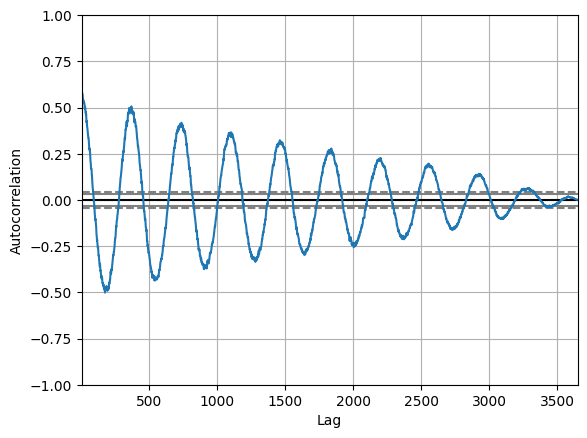

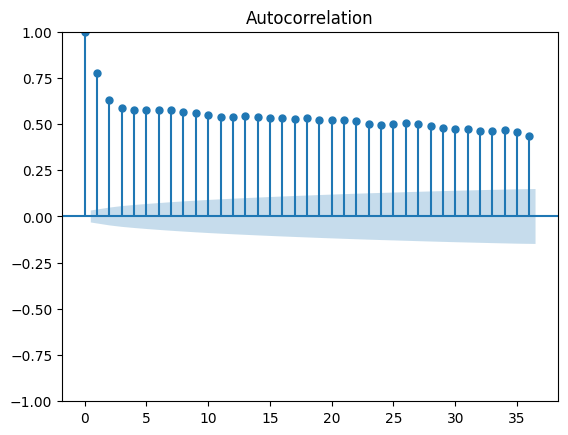

In [89]:
pd.plotting.autocorrelation_plot(df['y']);
plot_acf(df['y']);

On the first plot autocorelation has period equal 360.

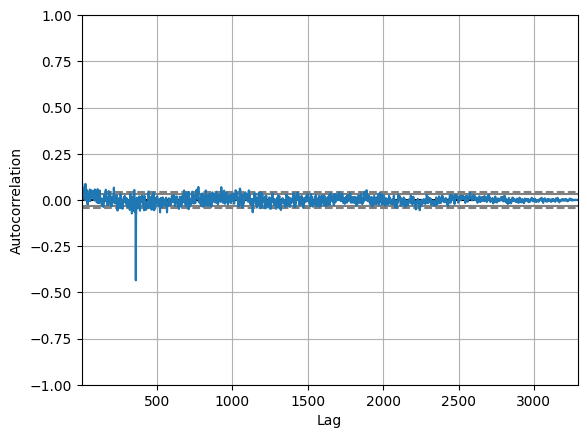

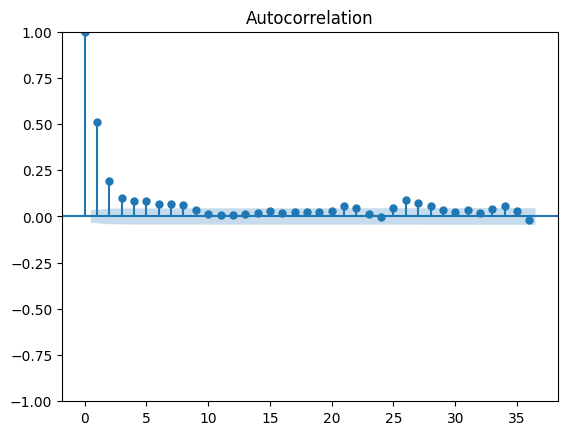

In [90]:
pd.plotting.autocorrelation_plot(df['y_seasonal_diff'].dropna());
plot_acf(df['y_seasonal_diff'].dropna());

## 3. Predicting Time series: AR Model

An autoregressive model uses a linear combination of past values of the target to make forecasts. Of course, the regression is made against the target itself. Mathematically, an $AR(p)$ model is expressed as:<br><br>

$$
y_{t+1} = b_0 + b_1 * y_{t} + b_2 * y_{t - 2} + ... + + b_2 * y_{t - p}
$$
$b_i$ - regression coefficients<br>
$p$ - number of lags

Usually, autoregressive models are applied to stationary time series only. This constrains the range of the parameters $b$.

The partial autocorrelation of an AR(p) process equals zero at lag which is not bigger than an order of $p$ and provides a good model for the correlation between
$x_1$ an $x_{p+1}$, so the appropriate maximum lag is the one beyond which the partial autocorrelations are all zero. Partial autocorrelation can be plotted using `statsmodels.graphics.tsaplots.plot_pacf`

Please, select `p` parameter using an autocorrelation plot and make forecast using AR model. But first, split data on train and test.

In [91]:
split_index = round(len(df) * 0.8)

df_train = df.iloc[:split_index]  
df_test = df.iloc[split_index:] 

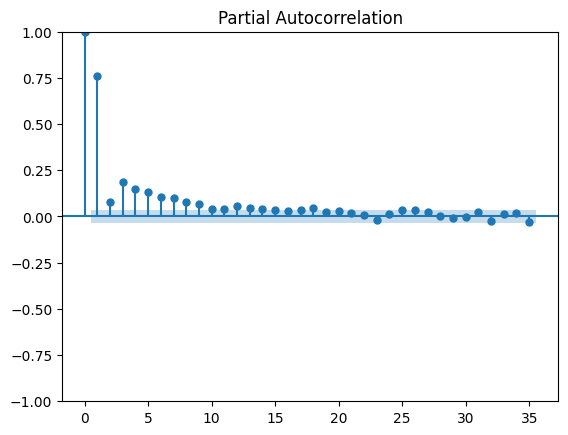

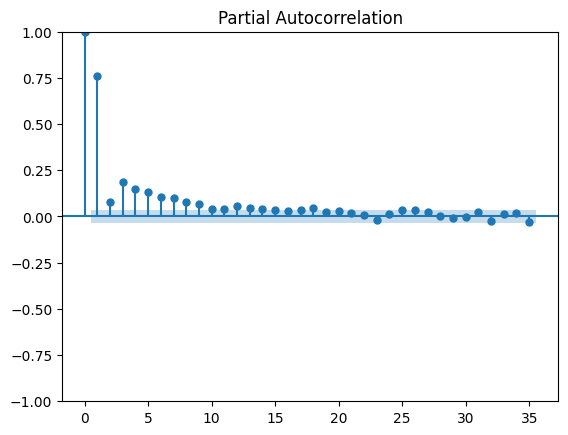

In [92]:
plot_pacf(df_train['y'])

In [93]:
p = 9

model = AutoReg(df_train['y'].dropna(), lags=p, seasonal=True, period=360).fit()

forecast_steps = len(df_test)
forecast = model.predict(start=len(df_train), end=len(df_train) + forecast_steps - 1)

df_forecast = df_test.copy()
df_forecast['y'] = forecast[-forecast_steps:].values


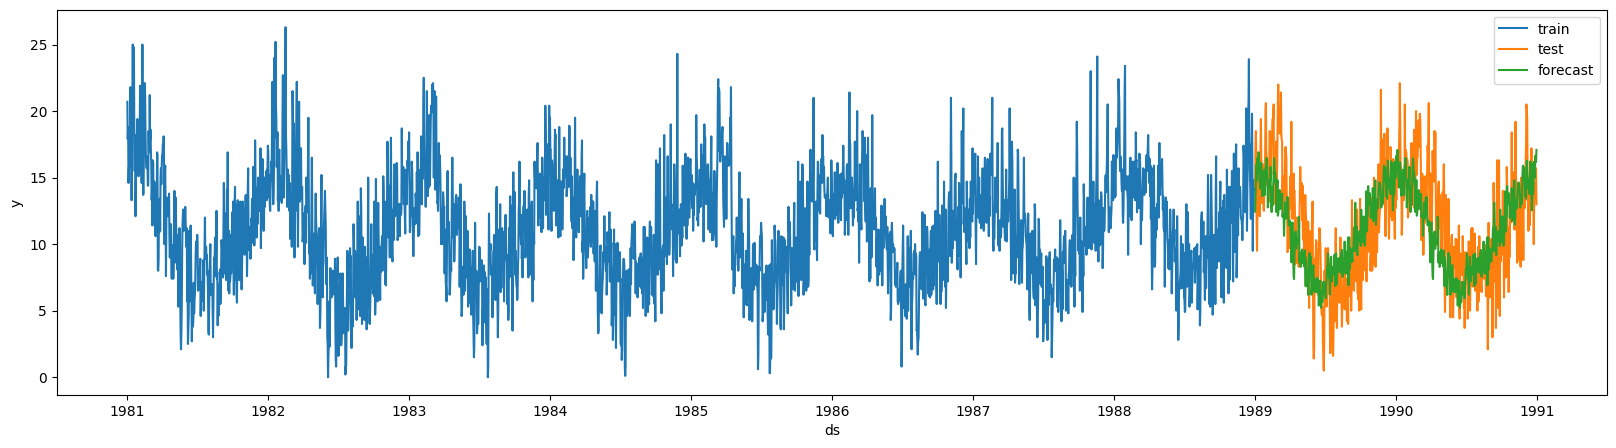

In [94]:
plt.figure(figsize=(20, 5))
plt.plot(df_train['y'], label='train')
plt.plot(df_test['y'], label='test')
plt.plot(df_forecast['y'], label='forecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

AR model RMSE:

In [95]:
np.sqrt(mean_squared_error(df_test['y'], df_forecast['y']))

3.158827919024839